# End to End Matching Example

Please run [Record-Linkage-Example.ipynb](Record-Linkage-Example.ipynb) before this one in order to get the trained model at `../trained-models/notebooks/rl/rl-model.ckpt`.

## Boilerplate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
import sys

sys.path.insert(0, '..')

In [4]:
import entity_embed

In [5]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

## Loading Test Data

In [6]:
import json
from ordered_set import OrderedSet

def load_pair_set(filepath):
    with open(filepath, 'r') as f:
        test_pos_pair_set = json.load(f)
        return OrderedSet(tuple(pair) for pair in test_pos_pair_set)

train_pos_pair_set = load_pair_set('../trained-models/notebooks/rl/rl-train-pos-pairs.json')
valid_pos_pair_set = load_pair_set('../trained-models/notebooks/rl/rl-valid-pos-pairs.json')
test_pos_pair_set = load_pair_set('../trained-models/notebooks/rl/rl-test-pos-pairs.json')

In [7]:
import json

def load_record_dict(filepath):
    with open(filepath, 'r') as f:
        record_dict = json.load(f)
        return {int(id_): record for id_, record in record_dict.items()}

train_record_dict = load_record_dict('../trained-models/notebooks/rl/rl-train-records.json')
valid_record_dict = load_record_dict('../trained-models/notebooks/rl/rl-valid-records.json')
test_record_dict = load_record_dict('../trained-models/notebooks/rl/rl-test-records.json')

## Loading Model

In [8]:
from entity_embed import LinkageEmbed

model = LinkageEmbed.load_from_checkpoint('../trained-models/notebooks/rl/rl-model.ckpt')

## Blocking

In [9]:
%%time

eval_batch_size = 64
ann_k = 100
sim_threshold = 0.3

train_found_pair_set = model.predict_pairs(
    record_dict=train_record_dict,
    batch_size=eval_batch_size,
    ann_k=ann_k,
    sim_threshold=sim_threshold,
    show_progress=True,
)

# batch embedding:   0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 39.5 s, sys: 1.04 s, total: 40.5 s
Wall time: 7.37 s


In [10]:
%%time

valid_found_pair_set = model.predict_pairs(
    record_dict=valid_record_dict,
    batch_size=eval_batch_size,
    ann_k=ann_k,
    sim_threshold=sim_threshold,
    show_progress=True,
)

# batch embedding:   0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 40.6 s, sys: 1.78 s, total: 42.4 s
Wall time: 7.61 s


In [11]:
%%time

test_found_pair_set = model.predict_pairs(
    record_dict=test_record_dict,
    batch_size=eval_batch_size,
    ann_k=ann_k,
    sim_threshold=sim_threshold,
    show_progress=True,
)

# batch embedding:   0%|          | 0/43 [00:00<?, ?it/s]

CPU times: user 1min 48s, sys: 4.24 s, total: 1min 52s
Wall time: 19.5 s


In [12]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(len(test_found_pair_set), len(test_record_dict))

9.463104325699746

In [13]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(test_found_pair_set, test_pos_pair_set)

(0.029693081857642224, 0.993573264781491)

## Matching: Compare

Make a dataframe `df` with all records (train, valid, test) to add additional features:

In [14]:
record_dict = {**train_record_dict, **valid_record_dict, **test_record_dict}

In [15]:
import pandas as pd

df = pd.DataFrame.from_dict(record_dict, orient='index')
df = df.drop(columns='id')

In [16]:
df['all'] = df.agg('{0[name]} - {0[description]} - {0[manufacturer]} - {0[price]}'.format, axis=1)
df['price'] = pd.to_numeric(df['price'].str.replace(' ', ''), errors='coerce')
df.head(3)

,name,description,manufacturer,price,__source,cluster,all
1728,filemaker pro 8 . 5 5 - user pack,system requirements macintosh macintosh comput...,,1149.00,google,1561,filemaker pro 8 . 5 5 - user pack - system req...
255,diskeeper 2007 pro premier 5 - lic pack,- marketing information : diskeeper pro premie...,diskeeper corporation,736.66,amazon,1207,diskeeper 2007 pro premier 5 - lic pack - - ma...
2889,emc securid appl mnt - ent / std 17mo per u 2k...,,,16.00,google,2231,emc securid appl mnt - ent / std 17mo per u 2k...


Replace all `record_dict`s (train, valid, test) to add additional features:

In [17]:
train_record_dict = df.loc[train_record_dict.keys()].to_dict(orient='index')
valid_record_dict = df.loc[valid_record_dict.keys()].to_dict(orient='index')
test_record_dict = df.loc[test_record_dict.keys()].to_dict(orient='index')

del df

In [18]:
import textdistance as td
import math

def token_ops(func):
    def new_func(x, y):
        return func(x.split(), y.split())    
    return new_func

def empty_str(x, y):
    return int(not x or not y)

def empty_num(x, y):
    return int(not x or not y or math.isnan(x) or math.isnan(y))

def zero_if_empty(x):
    if not x or math.isnan(x):
        return 0
    else:
        return x

def abs_diff(x, y):
    return abs(zero_if_empty(x) - zero_if_empty(y))

def abs_diff_log10(x, y, min_val=math.log10(1e-5)):
    diff = abs_diff(x, y)
    if diff > 0:
        return max(math.log10(diff), min_val)
    else:
        return min_val

SIM_FUNC_DICT = {
    ("all", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("all", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("all", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("all", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("description", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("description", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("description", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("description", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("manufacturer", "empty_str"): empty_str,
    ("manufacturer", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("manufacturer", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("manufacturer", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("manufacturer", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("name", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("name", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("name", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("name", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("price", "empty_num"): empty_num,
    ("price", "abs_diff"): abs_diff,
    ("price", "abs_diff_log10"): abs_diff_log10,
}

def record_sim_func(record_pair):
    record_left, record_right = record_pair
    feature_dict = {}
    
    for (field, sim_func_name), sim_func in SIM_FUNC_DICT.items():
        sim = sim_func(record_left[field], record_right[field])
        feature_dict[f"{field}_{sim_func_name}"] = sim
    
    return feature_dict

In [19]:
%%time

pair = next(iter(test_pos_pair_set))
id_left, id_right = pair
feature_dict = record_sim_func((test_record_dict[id_left], test_record_dict[id_right]))

# display(test_record_dict[id_left], test_record_dict[id_right])
feature_dict

CPU times: user 3.35 ms, sys: 158 µs, total: 3.51 ms
Wall time: 3.26 ms


{'all_jaccard': 0.3416666666666667,
 'all_overlap': 0.8541666666666666,
 'all_damerau_levenshtein': 0.37777777777777777,
 'all_jaro_winkler': 0.6369393860803791,
 'description_jaccard': 0.3366336633663367,
 'description_overlap': 0.9714285714285714,
 'description_damerau_levenshtein': 0.37821482602118006,
 'description_jaro_winkler': 0.8748461524552321,
 'manufacturer_empty_str': 1,
 'manufacturer_jaccard': 0.0,
 'manufacturer_overlap': 0.0,
 'manufacturer_damerau_levenshtein': 0.0,
 'manufacturer_jaro_winkler': 0.0,
 'name_jaccard': 0.19999999999999996,
 'name_overlap': 0.4,
 'name_damerau_levenshtein': 0.5121951219512195,
 'name_jaro_winkler': 0.6423441734417343,
 'price_empty_num': 1,
 'price_abs_diff': 62920.89,
 'price_abs_diff_log10': 4.798794856979781}

In [20]:
from collections import defaultdict
import multiprocessing
from tqdm.auto import tqdm

def compare_pairs(record_dict, found_pair_set):
    all_feature_dict = defaultdict(list)
    chunksize = 100
    tasks = (
        (record_dict[id_left], record_dict[id_right])
        for (id_left, id_right)
        in found_pair_set
    )

    with multiprocessing.Pool() as pool:
        for feature_dict in tqdm(
            pool.imap(record_sim_func, tasks, chunksize=chunksize),
            total=len(found_pair_set)
        ):
            for feature, val in feature_dict.items():
                all_feature_dict[feature].append(val)

        pool.close()
        pool.join()
    
    return pd.DataFrame(all_feature_dict, index=pd.MultiIndex.from_tuples(found_pair_set))

In [21]:
%%time

train_feature_df = compare_pairs(train_record_dict, train_found_pair_set)

  0%|          | 0/2608 [00:00<?, ?it/s]

CPU times: user 129 ms, sys: 113 ms, total: 241 ms
Wall time: 963 ms


In [22]:
%%time

valid_feature_df = compare_pairs(valid_record_dict, valid_found_pair_set)

  0%|          | 0/2954 [00:00<?, ?it/s]

CPU times: user 154 ms, sys: 108 ms, total: 262 ms
Wall time: 1.07 s


In [23]:
%%time

test_feature_df = compare_pairs(test_record_dict, test_found_pair_set)

  0%|          | 0/26033 [00:00<?, ?it/s]

CPU times: user 1.68 s, sys: 351 ms, total: 2.04 s
Wall time: 8.09 s


## Matching: Compare - Additional Features

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf_vectorizer(train_record_dict, valid_record_dict, field='all'):
    tfidf_vectorizer = TfidfVectorizer(
        analyzer='char',
        ngram_range=(2,4),
        min_df=2
    )
    train_valid_record_dict = {**train_record_dict, **valid_record_dict}
    tfidf_vectorizer.fit(record[field] for record in train_valid_record_dict.values())
    return tfidf_vectorizer

tfidf_vectorizer = get_tfidf_vectorizer(train_record_dict, valid_record_dict)
tfidf_vectorizer

TfidfVectorizer(analyzer='char', min_df=2, ngram_range=(2, 4))

In [25]:
import numpy as np

def add_tfidf_feature(feature_df, record_dict, found_pair_set, field='all'):
    tfidf_matrix = tfidf_vectorizer.transform(record[field] for record in record_dict.values())

    id_to_idx = {id_: idx for idx, id_ in enumerate(record_dict.keys())}
    left_idx = [id_to_idx[left_id] for left_id, __ in found_pair_set]
    right_idx = [id_to_idx[right_id] for __, right_id in found_pair_set]
    tfidf_sim = tfidf_matrix[left_idx].multiply(tfidf_matrix[right_idx]).sum(axis=1)

    feature_df[f'{field}_tfidf'] = tfidf_sim

In [26]:
%%time

add_tfidf_feature(train_feature_df, train_record_dict, train_found_pair_set)

CPU times: user 401 ms, sys: 3.86 ms, total: 405 ms
Wall time: 407 ms


In [27]:
%%time

add_tfidf_feature(valid_feature_df, valid_record_dict, valid_found_pair_set)

CPU times: user 409 ms, sys: 7.87 ms, total: 417 ms
Wall time: 419 ms


In [28]:
%%time

add_tfidf_feature(test_feature_df, test_record_dict, test_found_pair_set)

CPU times: user 1.41 s, sys: 84.5 ms, total: 1.49 s
Wall time: 1.51 s


## Matching: Classify

In [29]:
train_valid_feature_df = pd.concat([train_feature_df, valid_feature_df])
train_valid_feature_df.head(3)

,,all_jaccard,all_overlap,all_damerau_levenshtein,all_jaro_winkler,description_jaccard,description_overlap,description_damerau_levenshtein,description_jaro_winkler,manufacturer_empty_str,manufacturer_jaccard,...,manufacturer_damerau_levenshtein,manufacturer_jaro_winkler,name_jaccard,name_overlap,name_damerau_levenshtein,name_jaro_winkler,price_empty_num,price_abs_diff,price_abs_diff_log10,all_tfidf
111,2051,0.113636,0.263158,0.259819,0.652338,0.046875,0.15,0.230769,0.616741,1,0.0,...,0.0,0.0,0.0625,0.200000,0.234375,0.582953,0,11.22,1.049993,0.189766
716,1636,0.192308,0.416667,0.212766,0.580096,0.000000,0.00,0.000000,0.000000,1,0.0,...,0.0,0.0,0.1250,0.333333,0.171429,0.462302,0,1642.61,3.215534,0.035008
987,3033,0.097826,0.257143,0.239316,0.612835,0.059701,0.16,0.243137,0.623390,1,0.0,...,0.0,0.0,0.0000,0.000000,0.125000,0.443338,0,2.02,0.305351,0.101822


In [30]:
train_true_y = np.array([pair in train_pos_pair_set for pair in train_found_pair_set], dtype='i4')
valid_true_y = np.array([pair in valid_pos_pair_set for pair in valid_found_pair_set], dtype='i4')
test_true_y = np.array([pair in test_pos_pair_set for pair in test_found_pair_set], dtype='i4')

In [31]:
train_valid_true_y = np.concatenate([train_true_y, valid_true_y])

In [32]:
%%time

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=random_seed)
clf.fit(train_valid_feature_df, train_valid_true_y)

CPU times: user 1.2 s, sys: 38.4 ms, total: 1.24 s
Wall time: 327 ms


RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

In [33]:
if hasattr(clf, 'oob_score_'):
    clf.oob_score_

In [34]:
from sklearn.metrics import accuracy_score

train_valid_pred_y = clf.predict(train_valid_feature_df)
accuracy_score(train_valid_pred_y, train_valid_true_y)

1.0

In [35]:
if hasattr(clf, 'feature_importances_'):
    feature_importances = dict(zip(train_valid_feature_df.columns, clf.feature_importances_))
    sorted(feature_importances.items(), key=lambda kv: kv[1], reverse=True)

In [36]:
from sklearn.metrics import precision_recall_fscore_support

pred_y = clf.predict(test_feature_df)
precision_recall_fscore_support(test_true_y, pred_y, labels=[1])

(array([0.53705398]), array([0.75937904]), array([0.62915327]), array([773]))

In [37]:
cls_found_pair_set = OrderedSet(test_feature_df[pred_y.astype(bool)].index)

precision_and_recall(cls_found_pair_set, test_pos_pair_set)

(0.5370539798719122, 0.7544987146529563)

In [38]:
# # for x, y in list(test_feature_df[~pred_y.astype(bool)][['all_tfidf']].index)[:40]:
# for x, y in list(test_pos_pair_set - cls_found_pair_set)[:40]:
#     display(((x, y), test_record_dict[x]['name'], test_record_dict[y]['name']))

In [39]:
pair = (855, 1552)
display(test_record_dict[pair[0]], test_record_dict[pair[1]])
test_feature_df.loc[pair]

{'name': 'micromat podlock ( mac )',
 'description': "podlock is for anyone who gets a lot of use out of their ipods and wants to keep them secure . podlock allows you to seamlessly backup and restore your primary ipod volume to your macintosh drive ( excluding your music files ). it also optimizes the data on your ipod . by using podlock ' s defragment tool your ipod ' s drive will run faster . songs will load more quickly and data can be retrieved much faster . hide your important files . in an invisible partition for added security .",
 'manufacturer': 'micromat',
 'price': 69.0,
 '__source': 'amazon',
 'cluster': 886,
 'all': "micromat podlock ( mac ) - podlock is for anyone who gets a lot of use out of their ipods and wants to keep them secure . podlock allows you to seamlessly backup and restore your primary ipod volume to your macintosh drive ( excluding your music files ). it also optimizes the data on your ipod . by using podlock ' s defragment tool your ipod ' s drive will ru

{'name': 'micromat podlock ipod utility software',
 'description': 'system requirements : a macintosh running mac os x 10 . 3 or greater . an ipod .',
 'manufacturer': '',
 'price': 39.99,
 '__source': 'google',
 'cluster': 886,
 'all': 'micromat podlock ipod utility software - system requirements : a macintosh running mac os x 10 . 3 or greater . an ipod . -  - 39 . 99'}

all_jaccard                          0.127119
all_overlap                          0.517241
all_damerau_levenshtein              0.199623
all_jaro_winkler                     0.583725
description_jaccard                  0.066667
description_overlap                  0.388889
description_damerau_levenshtein      0.139344
description_jaro_winkler             0.545952
manufacturer_empty_str               1.000000
manufacturer_jaccard                 0.000000
manufacturer_overlap                 0.000000
manufacturer_damerau_levenshtein     0.000000
manufacturer_jaro_winkler            0.000000
name_jaccard                         0.250000
name_overlap                         0.400000
name_damerau_levenshtein             0.500000
name_jaro_winkler                    0.861930
price_empty_num                      0.000000
price_abs_diff                      29.010000
price_abs_diff_log10                 1.462548
all_tfidf                            0.406963
Name: (855, 1552), dtype: float64

<Figure size 1152x720 with 0 Axes>

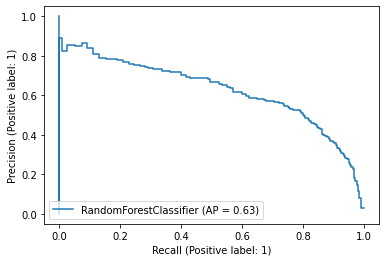

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

plt.figure(figsize=(16,10))

disp = plot_precision_recall_curve(clf, test_feature_df, test_true_y)